In [1]:
from __future__ import print_function

from __future__ import division

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import numpy as np
import tensorflow as tf

In [4]:
import time

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
import cv2

In [7]:
input_dim = 416

bn_variance_epsilon = 1e-6


batch_size = 1

confidence_threshold = 0.55

iou_threshold=0.45

max_output_size = 1000

In [8]:
def print_tensor_info(t):
      print(t.op.name, ' ', t.get_shape().as_list())

In [9]:
# !python -m wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg 

In [10]:
blockList = []
current_block = {}
with open('cfg/yolov3.cfg') as cfg:
    line = cfg.readline()
    while line:
        if line.startswith("#"):
            line = cfg.readline()
            continue
        if line.startswith("["):
            if current_block != {}:
                blockList.append(current_block)
            current_block = {}
            current_block["type"] = line[1:-2]
        else:
            if "=" in line:
    #             print(line)
                key, value = line.split("=")
                key = key.strip()
                value = value.strip()
    #             print(key, value)
                current_block[key] = value

        line = cfg.readline()
    if current_block != {}:
        blockList.append(current_block)

In [11]:
yolo_blocks = []
for block in blockList:
    if block["type"] == "yolo":
        yolo_blocks.append(block)

In [12]:
yolo_blocks[0]

{'type': 'yolo',
 'mask': '6,7,8',
 'anchors': '10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326',
 'classes': '80',
 'num': '9',
 'jitter': '.3',
 'ignore_thresh': '.7',
 'truth_thresh': '1',
 'random': '1'}

In [13]:
def yolo_layer(forward_input, block_info):
    shape = forward_input.get_shape()
    
    if len(shape.as_list()) == 4:
        shape_list = [int(shape[0]), int(shape[1]), int(shape[2]), 3, int(shape[3]) // 3]
        yolo_tensor = tf.reshape(forward_input, shape_list)
    else:
        yolo_tensor = forward_input
    # yolo_tensor的形状为(1, 13, 13, 3, 85)
    # 85 = 1 （objectness) + 4 (bbox: x_center_in_gird, y_center_in_gird, width, height) + 80 (80 classes confidence)
    
    # stride from input image to feature map
    # 数据输入为416 * 416， 那么第一个yolo层是13 * 13， stride是32.
    # 第二个yolo层的stride为16，第三个为8
    stride = input_dim // shape.as_list()[1]

    
    # 总共9个prior box大小，每个yolo层使用属于它的3个
    mask_list = [ int(x) for x in block_info["mask"].split(",")]
    anchors_list = [ int(x.strip()) for x in block_info["anchors"].split(",")]
    prior_width_height = [ tuple([anchors_list[2*i], anchors_list[2*i + 1] ]) for i in mask_list]
    
    assert(len(prior_width_height) == 3)
    
    # 三个prior box 输出的bbox

    box_width_height1 = tf.exp(yolo_tensor[:, :, :, 0:1, 2:4]) * prior_width_height[0] 
    box_width_height2 = tf.exp(yolo_tensor[:, :, :, 1:2, 2:4]) * prior_width_height[1] 
    box_width_height3 = tf.exp(yolo_tensor[:, :, :, 2:3, 2:4]) * prior_width_height[2] 
    

    box_width_height = tf.concat([box_width_height1, box_width_height2, box_width_height3], axis=3)

    
    confidence_tensor = tf.sigmoid(yolo_tensor[:, :, :, :, 4:])

    
    # 过滤出objectness大于threshold的物体索引
    # result_indexes的形状为( N, H, W, anchor)
    result_indexes = tf.where(tf.greater_equal(tf.sigmoid(confidence_tensor[:, :, :, :, 0]), confidence_threshold))
    
    
    # TODO 此处若无+1 操作，则bbox坐标不对
#     gird_x_y_raw = tf.cast(result_indexes[:,1:3],  tf.float32)
    gird_x_y_raw = tf.cast(result_indexes[:,1:3],  tf.float32) + 1
    
    # indexes 中坐标为（N, H, W, anchor) 需要将H,W 互换
    gird_x_y = tf.concat([gird_x_y_raw[:,1:], gird_x_y_raw[:,0:1]] , axis=1)
    
    
    #过滤检测结果
    result_boxes = tf.gather_nd(yolo_tensor, result_indexes)
    
    #x, y 坐标是在这个网格中的相对坐标
    center_x_y = tf.sigmoid(result_boxes[:, 0:2])
    # 转化为全图绝对坐标
    output_center_x_y = (gird_x_y + center_x_y) * stride
    
    output_width_height =  tf.gather_nd(box_width_height, result_indexes)
    
    x_min = tf.maximum(output_center_x_y[:, 0:1] - 0.5 * output_width_height[:, 0:1], 0)
    x_max = tf.minimum(output_center_x_y[:, 0:1] + 0.5 * output_width_height[:, 0:1], input_dim)
    y_min = tf.maximum(output_center_x_y[:, 1:2] - 0.5 * output_width_height[:, 1:2], 0)
    y_max = tf.minimum(output_center_x_y[:, 1:2] + 0.5 * output_width_height[:, 1:2], input_dim)

    output_xmin_ymin_xmax_y_max = tf.concat([x_min, y_min, x_max, y_max], axis=1)
    
    # 将绝对的坐标值转为相对坐标值
    output_xmin_ymin_xmax_y_max_float = output_xmin_ymin_xmax_y_max / input_dim
        
    classes_confidence = tf.gather_nd(confidence_tensor[:, :, :, :,1:], result_indexes)
    index_int = tf.argmax(classes_confidence ,axis=1)[ :, tf.newaxis]
    max_index = tf.cast(index_int, dtype=tf.float32)
    max_confidence = tf.reduce_max(classes_confidence ,axis=1)[ :, tf.newaxis]
    
    # 输出的张量形状为 (None, 6)
    # 6 = 4 (bbox),  1 (class_index), 1 (class_confidence)
    yolo_output = tf.concat([output_xmin_ymin_xmax_y_max_float,  max_index, max_confidence], axis=1)
    return yolo_output

In [14]:
def make_one_layer(forward_input, block, layersList, np_weights,  weights_ptr):
    # 根据block信息，从上一层构建下一层
    
    forward_output = None
    
    # 读取yolov3.weights权重文件的指针
    next_weights_ptr = 0
    
    if block['type'] == "net":
#         forward_output = tf.placeholder(dtype=tf.float32, shape = 
#                                         [batch_size, int(block["height"]), int(block["width"]), int(block["channels"])])
        forward_output = tf.placeholder(dtype=tf.float32, shape = 
                                        [batch_size, input_dim, input_dim, int(block["channels"])])
        with tf.name_scope("input") as scope:
            return tf.identity(forward_output, name="x" ), weights_ptr
    if block["type"] == "convolutional":
        input_filters = int(forward_input.get_shape()[3])
        output_filters =  int(block["filters"])
        kernel_size = int(block["size"])
        kernel_shape = [int(block["size"]),  int(block["size"]), input_filters, output_filters]
        stride = int(block["stride"])
        strides = [1, stride, stride, 1]
        pad = (kernel_size - 1) / 2 
        # batch norm load more weights
        try:
            batch_norm = block["batch_normalize"]
        except:
            batch_norm = 0
        if batch_norm:
            
            #batch norm weights
            bn_offset = np_weights[weights_ptr:weights_ptr+output_filters]
            weights_ptr += output_filters
            
            bn_scale = np_weights[weights_ptr:weights_ptr+output_filters]
            weights_ptr += output_filters
            
            bn_mean = np_weights[weights_ptr:weights_ptr+output_filters]
            weights_ptr += output_filters
            
            bn_var = np_weights[weights_ptr:weights_ptr+output_filters]
            weights_ptr += output_filters
            
            #conv filter weights
            conv_weights_num = output_filters * input_filters * kernel_size * kernel_size
            np_conv_weights = np_weights[weights_ptr:weights_ptr+conv_weights_num]
            weights_ptr += conv_weights_num
            np_conv_weights = np_conv_weights.reshape( output_filters, input_filters, kernel_size, kernel_size)
#             print(np_conv_weights.shape)
#             print(tf.constant(np_conv_weights, dtype=tf.float32))

#             conv_kernel =  (tf.transpose(tf.constant(np_conv_weights, dtype=tf.float32), [2, 3, 1, 0]))
            # 此处之前使用tensorflow来做权重张量转置操作，很费时。不需要重复转置，所以使用numpy一次转置就够了
            np_conv_weights = np.transpose(np_conv_weights, [2, 3, 1, 0])
            conv_kernel =  tf.constant(np_conv_weights, dtype=tf.float32)
    
            conv_output = tf.nn.conv2d(forward_input, conv_kernel, strides, "SAME")
            
            bn_output = tf.nn.batch_normalization(conv_output, tf.constant(bn_mean, dtype=tf.float32), 
                                                 tf.constant(bn_var, dtype=tf.float32), tf.constant(bn_offset, dtype=tf.float32),
                                                 tf.constant(bn_scale, dtype=tf.float32), bn_variance_epsilon)
            
            if block["activation"] == "leaky":
                leaky_relu_outpu = tf.nn.leaky_relu(bn_output, alpha=0.1)
                # layersList.append(leaky_relu_outpu)
                with tf.name_scope("conv"+str(len(layersList))) as scope:
                    return tf.identity(leaky_relu_outpu, name=scope ), weights_ptr
            
            # layersList.append(bn_output)
            raise Exception("unhandled condition")
            return bn_output, weights_ptr
        else:
            # no batch_norm
            
            #conv bias
            conv_bias = np_weights[weights_ptr:weights_ptr+output_filters]
            weights_ptr += output_filters
            
            #conv filter weights
            conv_weights_num = output_filters * input_filters * kernel_size * kernel_size
            np_conv_weights = np_weights[weights_ptr:weights_ptr+conv_weights_num]
            weights_ptr += conv_weights_num
            np_conv_weights = np_conv_weights.reshape( output_filters, input_filters, kernel_size, kernel_size)
            
#             conv_kernel =  (tf.transpose(tf.constant(np_conv_weights, dtype=tf.float32), [2, 3, 1, 0]))
            
            np_conv_weights = np.transpose(np_conv_weights, [2, 3, 1, 0])
            conv_kernel =  tf.constant(np_conv_weights, dtype=tf.float32)
            
            
            conv_output = tf.nn.conv2d(forward_input, conv_kernel, strides, "SAME")
            
            conv_bias_output = tf.nn.bias_add(conv_output, tf.constant(conv_bias, dtype=tf.float32))
            
            # layersList.append(conv_bias_output)
            with tf.name_scope("conv"+str(len(layersList))) as scope:
                return tf.identity(conv_bias_output, name=scope), weights_ptr
    
    if  block["type"] == "route":
        layers = []
        if "," not in block["layers"]:
            layers.append(int(block["layers"]))
        else:
            for l in block["layers"].split(","):
                layers.append(int(l.strip()))
        
#         for l in layers:
#             if l <0:
#                 l = len(layersList) + l


        # 此处，因为layerlist开头多了一个input_data的layer，所以concat的位置应该向后一位
        layers_new=[]
        for l in layers:
            if l<0:
                layers_new.append(len(layersList) + l)
            else:
                layers_new.append( l +1 )
        layers = layers_new
        
        if len(layers) == 1:
            with tf.name_scope("route"+str(len(layersList))) as scope:
                return tf.identity(layersList[layers[0]], name= scope), weights_ptr
        else:
            
            to_concat_list = [layersList[i] for i in layers]
            concat_result =tf.concat( to_concat_list, axis=3)
            
            with tf.name_scope("route"+str(len(layersList))) as scope:
                return tf.identity(concat_result, name=scope), weights_ptr
        

    if  block["type"] == "shortcut":
        prior_index = int(block["from"])
#         print("prior_index = ", prior_index)
#         print("layersList[prior_index]", layersList[prior_index])
        residual_layer = forward_input + layersList[prior_index]
    
        with tf.name_scope("shortcut"+str(len(layersList))) as scope:
            return tf.identity(residual_layer, name= scope), weights_ptr
        
    
    if  block["type"] == "upsample":
        new_height = int(block["stride"]) * int(forward_input.get_shape()[1])
        new_width = int(block["stride"]) * int(forward_input.get_shape()[2])
        
        upsample_layer = tf.image.resize_bilinear(forward_input, [new_height, new_width])
        
        with tf.name_scope("upsample"+str(len(layersList))) as scope:
            return tf.identity(upsample_layer, name= scope), weights_ptr
        
    
    if  block["type"] == "yolo":
        
        with tf.name_scope("yolo"+str(len(layersList))) as scope:
            return tf.identity(yolo_layer(forward_input, block_info=block), name=scope), weights_ptr
        
    
    raise Exception('unkown block type')

In [15]:
# !python -m wget https://pjreddie.com/media/files/yolov3.weights

In [16]:
fp = open("cfg/yolov3.weights", "rb")
#The first 5 values are header information 
# 1. Major version number
# 2. Minor Version Number
# 3. Subversion number 
# 4,5. Images seen by the network (during training)
header = np.fromfile(fp, dtype = np.int32, count = 5)
print(header)

[       0        2        0 32013312        0]


In [17]:
yolo_weights = np.fromfile(fp, dtype = np.float32)

In [18]:
yolo_weights.shape

(62001757,)

In [19]:
layers_list = []
ptr = 0
temp_layer =None
yolo_out_list = []

for block in blockList:
#     print(block["type"])
    pre_ptr = ptr
    temp_layer, ptr = make_one_layer(forward_input=temp_layer, block=block, 
                         layersList=layers_list, np_weights=yolo_weights, weights_ptr=ptr)
    print_tensor_info(temp_layer)
    layers_list.append(temp_layer)
 
    if block["type"] == "yolo":
        yolo_out_list.append(temp_layer)
    if block["type"] == "convolutional":
        try:
            batch_norm = block["batch_normalize"]
        except:
            batch_norm = 0
        if batch_norm:
            print("convolution layer with batch_norm weights float num: %d" % (ptr - pre_ptr))
        else:
            print("convolution layer without batch_norm weights float num: %d" % (ptr - pre_ptr))
 

input/x   [1, 416, 416, 3]
conv1   [1, 416, 416, 32]
convolution layer with batch_norm weights float num: 992
conv2   [1, 208, 208, 64]
convolution layer with batch_norm weights float num: 18688
conv3   [1, 208, 208, 32]
convolution layer with batch_norm weights float num: 2176
conv4   [1, 208, 208, 64]
convolution layer with batch_norm weights float num: 18688
shortcut5   [1, 208, 208, 64]
conv6   [1, 104, 104, 128]
convolution layer with batch_norm weights float num: 74240
conv7   [1, 104, 104, 64]
convolution layer with batch_norm weights float num: 8448
conv8   [1, 104, 104, 128]
convolution layer with batch_norm weights float num: 74240
shortcut9   [1, 104, 104, 128]
conv10   [1, 104, 104, 64]
convolution layer with batch_norm weights float num: 8448
conv11   [1, 104, 104, 128]
convolution layer with batch_norm weights float num: 74240
shortcut12   [1, 104, 104, 128]
conv13   [1, 52, 52, 256]
convolution layer with batch_norm weights float num: 295936
conv14   [1, 52, 52, 128]
con

In [20]:
assert(len(yolo_weights) - ptr == 0)

In [21]:
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth=True
sess = tf.Session(config=config) 
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [22]:
def nms(yolo_output_list):
    yolo_output_concat = tf.concat(yolo_output_list, axis=0)
    
    output_xmin_ymin_xmax_y_max = yolo_output_concat[:, 0:4]
    output_score = yolo_output_concat[:, 4]
    
    selected_index = tf.image.non_max_suppression(output_xmin_ymin_xmax_y_max, output_score,  max_output_size, iou_threshold)
    
    final_result = tf.gather(yolo_output_concat, selected_index)
    
    return final_result

In [23]:
y = nms(yolo_out_list)
y

<tf.Tensor 'GatherV2:0' shape=(?, 6) dtype=float32>

In [24]:
# !python -m wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg

# !python -m wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/horses.jpg

#  !python -m wget https://images2018.cnblogs.com/blog/1103587/201806/1103587-20180609102500112-1316429265.jpg -o car.jpg

In [25]:
plt.rcParams['figure.figsize'] = (20, 10)  

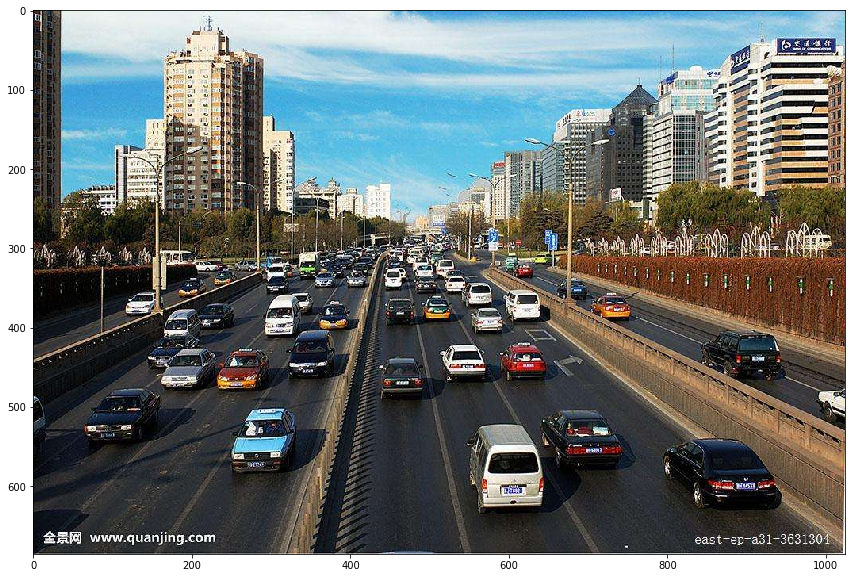

In [26]:
img =cv2.imread("data/car.jpg")
# img = cv2.resize(img,(input_dim,input_dim))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_float = img.astype(np.float32) / 256
img_float = cv2.resize(img_float,(input_dim,input_dim))

img_batch =  img_float.reshape(1,input_dim,input_dim,3)
plt.imshow(img)

In [27]:
init_op = tf.global_variables_initializer()
# sess.run(test_y)
r = (sess.run(y, feed_dict={layers_list[0].name: img_batch}))

start_time = time.time()
rounds =20
result_list =[]
for i in range(rounds):
    _ = (sess.run(y, feed_dict={layers_list[0].name: img_batch}))
duration = time.time() - start_time
ms_count = ( float(duration)/rounds) * 1000
print("cost time per round: %.2f ms" % ms_count)


# print(r)

cost time per round: 22.38 ms


In [28]:
# !python -m wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -o cfg/coco.names

In [29]:
coco_names = []
with open("cfg/coco.names") as f:
    name = f.readline()
    while name:
        coco_names.append(name.strip())
        name = f.readline()

print(coco_names)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [32]:
def draw_box(img, dets):
    img2 = img.copy()
    width = img2.shape[1]
    height =  img2.shape[0]
    for i in range(dets.shape[0]):

        top_left = (int(dets[i,0] * width), int(dets[i,1] * height))
        bottom_right = (int(dets[i,2] * width), int(dets[i,3] * height))
        
        img2 = cv2.rectangle(img2, top_left , bottom_right, (255,0,0),3,1,0)

        img2 = cv2.putText(img2, coco_names[int(dets[i,4])], top_left, cv2.FONT_HERSHEY_COMPLEX_SMALL,1.5, (0 ,125,0), 2)
    
    result = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    cv2.imwrite("data/result.jpg", result)
    plt.imshow(img2)


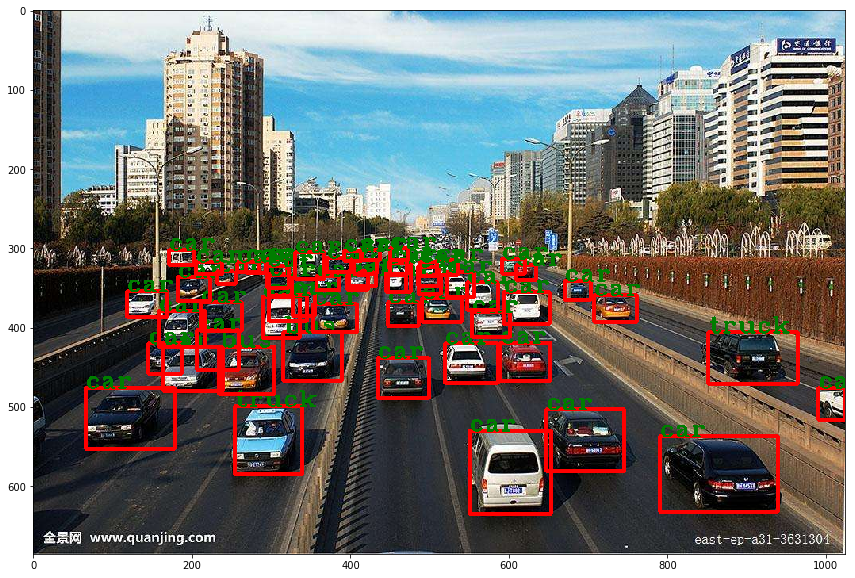

In [33]:
draw_box(img, r)